In [274]:
################################################################################
# Load dataset and split it into training and test set
################################################################################

import pandas as pd
import os
from tabulate import tabulate

dataset_name = "cic-iot"
sample_size = 100000

# Load dateset
df = pd.read_csv(os.getcwd() + f'/data/sample-{sample_size}-2.csv')

# Split dataset according to attack type
normal_df = df[df['label'] == 'BenignTraffic']
attack_df = df[df['label'] != 'BenignTraffic']

# Drop columns
normal_df = normal_df.drop(columns=['label'])
attack_df = attack_df.drop(columns=['label'])

# Split dataset into training and test set
normal_df_train = normal_df.sample(frac=0.8, random_state=42)
normal_df_test = normal_df.drop(normal_df_train.index)
attack_df_train = attack_df.sample(frac=0.8, random_state=42)
attack_df_test = attack_df.drop(attack_df_train.index)

# Print dataset sizes in a table
data = [
    ["Normal", normal_df.shape[0], normal_df_train.shape[0], normal_df_test.shape[0]],
    ["Attack", attack_df.shape[0], attack_df_train.shape[0], attack_df_test.shape[0]]
]
print(tabulate(data, headers=["Attack type", "Total", "Train", "Test"], tablefmt="grid"))

+---------------+---------+---------+--------+
| Attack type   |   Total |   Train |   Test |
+===============+=========+=========+========+
| Normal        |   10800 |    8640 |   2160 |
+---------------+---------+---------+--------+
| Attack        |   89200 |   71360 |  17840 |
+---------------+---------+---------+--------+


In [275]:
################################################################################
# Vector Store
################################################################################

import json
import numpy as np
from langchain_chroma import Chroma
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

train_set_size = sample_size
n_results = 10
embeddings = HuggingFaceEmbeddings()
vector_store = Chroma(
    collection_name=dataset_name,
    embedding_function=embeddings,
    persist_directory=f"./vector-stores/chroma-db-{train_set_size}-2")

normal_vectors = vector_store._collection.get(include=['embeddings'], where={'label': 'normal'})['embeddings']
normal_mean_vector = np.mean(normal_vectors, axis=0).tolist()
normal_documents = \
    vector_store._collection.query(query_embeddings=[normal_mean_vector], n_results=n_results)['documents'][0]

attack_vectors = vector_store._collection.get(include=['embeddings'], where={'label': 'attack'})['embeddings']
attack_mean_vector = np.mean(attack_vectors, axis=0).tolist()
attack_documents = \
    vector_store._collection.query(query_embeddings=[attack_mean_vector], n_results=n_results)['documents'][0]

normal_entries_dict = {}
for i, feat_name in enumerate(normal_df_train.columns.to_list()):
    normal_entries_dict[feat_name] = [json.loads(doc.replace("'", "\""))[i] for doc in normal_documents]

attack_entries_dict = {}
for i, feat_name in enumerate(attack_df_train.columns.to_list()):
    attack_entries_dict[feat_name] = [json.loads(doc.replace("'", "\""))[i] for doc in attack_documents]

In [276]:
################################################################################
# State
################################################################################

from langgraph.graph import MessagesState


class State(MessagesState):
    i: int
    macro_f1s: float

In [277]:
################################################################################
# Policy Evaluate Tool
################################################################################

import operator
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from typing import Annotated
from langchain_core.tools import tool

show_progress = False
operations = {'<': operator.lt, '>': operator.gt, '==': operator.eq, '<=': operator.le, '>=': operator.ge,
              '!=': operator.ne}


@tool
def policy_evaluate_tool(
        feature_name: Annotated[str, "Feature name"],
        value: Annotated[float, "Value"],
        op: Annotated[str, "Operator"]
) -> float:
    """Evaluate the policy and return the macro f1-score."""
    try:
        value = float(value)
    except ValueError:
        print("Value must be a number.")
    datasets = {"normal": normal_df_train, "attack": attack_df_train}
    y_pred = []
    y_true = []
    if op in operations:
        for attack_type, dataset in datasets.items():
            test_set_size = dataset.shape[0]
            for i in tqdm(range(test_set_size), ncols=100, desc=f"Predicting {attack_type} entries...",
                          disable=not show_progress):
                y_true.append(attack_type)
                y_pred.append("attack" if operations[op](dataset.iloc[i][feature_name], value) else "normal")
        c_report = classification_report(y_true, y_pred, digits=4, output_dict=True)
        return c_report['macro avg']['f1-score']
    else:
        raise ValueError(f"Unsupported operator: {op}")

In [278]:
################################################################################
# Policy Generator Node
################################################################################

from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic
import dotenv
import os

dotenv.load_dotenv(os.getcwd() + '/../.env')

# OpenAI
# llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)
# llm = ChatOpenAI(model="gpt-4o", temperature=0.1)

# Google Generative AI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0.1)
# llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", temperature=0.1)

# Anthropic
# llm = ChatAnthropic(model="claude-3-5-sonnet-latest", temperature=0.1)

llm_with_policy_evaluate_tool = llm.bind_tools([policy_evaluate_tool])

normal_entries = json.dumps(normal_entries_dict)
attack_entries = json.dumps(attack_entries_dict)


def policy_generator(state):
    ai_message = llm_with_policy_evaluate_tool.invoke(state["messages"])
    return {"messages": [ai_message]}

In [279]:
################################################################################
# Long-term Memory Write Tool
################################################################################

import sqlite3
from typing import List


@tool
def lt_memory_write_tool(policy: List[str]) -> bool:
    """
    Write a policy to the SQL database.

    Args:
        policy (List[str]): ['feature', 'condition', 'value', 'f1_score', 'comment']

    Returns:
        bool: True if the policy is successfully written to the database, False otherwise.
    """

    try:
        # Create a connection to a SQLite database
        db_name = "results/database.db"
        connection = sqlite3.connect(db_name)

        # Write data to the database
        table_name = "lt_memory"
        cursor = connection.cursor()

        # Create the table if it does not exist
        cursor.execute(
            f"CREATE TABLE IF NOT EXISTS {table_name} (feature TEXT PRIMARY KEY, condition TEXT, value TEXT, f1_score TEXT, comment TEXT)")

        # Insert the policy into the table
        cursor.execute(f"INSERT OR REPLACE INTO {table_name} VALUES (?, ?, ?, ?, ?)", [str(element) for element in policy])

        # Commit the changes
        connection.commit()

        # Close the connection
        connection.close()

        return True
    except Exception as e:
        print(e)
        return False


In [280]:
################################################################################
# Function for retrieving previous policies from Long-term Memory
################################################################################

import sqlite3


def get_previous_policies(as_string=False):
    try:
        # Create a connection to a SQLite database
        db_name = "results/database.db"
        connection = sqlite3.connect(db_name)
        connection.row_factory = sqlite3.Row

        # Read data from the database
        table_name = "lt_memory"
        cursor = connection.cursor()

        # Create the table if it does not exist
        cursor.execute(
            f"CREATE TABLE IF NOT EXISTS {table_name} (feature TEXT PRIMARY KEY, condition TEXT, value TEXT, f1_score TEXT, comment TEXT)")

        # Read the policies from the table
        cursor.execute(f"SELECT * FROM {table_name}")
        rows = cursor.fetchall()

        # Close the connection
        connection.close()

        fetched_policies = [dict(row) for row in rows]

        try:
            sorted_policies = sorted(fetched_policies, key=lambda x: float(x['f1_score']), reverse=True)
        except Exception as e:
            print(e)
            sorted_policies = fetched_policies

        if as_string:
            str_policies = []
            for sorted_policy in sorted_policies:
                policy = f"Policy {len(sorted_policies)}: {sorted_policy['feature']} {sorted_policy['condition']} {sorted_policy['value']}, F1-Score: {sorted_policy['f1_score']}, Comment: {sorted_policy['comment']}"
                str_policies.append(policy)
            return str_policies
        return sorted_policies
    except Exception as e:
        print(e)
        return []

In [281]:
################################################################################
# Persistence Filter Node
################################################################################

import uuid

llm_with_lt_memory_write_tool = llm.bind_tools([lt_memory_write_tool])


def persistence_filter(state):
    human_message = HumanMessage(f"""
    You have generated new policies. Your task is to compare these new policies with the previously generated ones and provide insightful comments about their relative strengths and weaknesses.

    Previous Policies:
    ```{get_previous_policies(as_string=True)}```

    Use the following steps to perform the task:

    1. Compare each newly generated policy with the corresponding policy (same feature) from the "Previous Policies" section.
    2. Identify the key differences in features, conditions, values, and f1-score. Determine which policy is better and why.
    3. Generate Comments:
        If the new policy outperforms the previous one, explain why (e.g., better value ranges, improved performance metrics).
        If the previous policy is better, specify what made it more effective.
        If there is no previous policy for comparison, use the default comment: "Initial policy."
        Note: Include previous policy details in the comments for reference.

    Example Comments:
    ```
    For the previous policy (x_count > 0.5), the value ranged from 0.5 to 0.7. When the value increased from 0.5 to 0.6, the F1-score improved from 0.8 to 0.9. However, increasing it further to 0.7 caused the F1-score to drop to 0.7. This indicates the optimal range is between 0.5 and 0.6.

    The new policy performs similarly to the previous one (x_count > 0.5), both achieving high F1-scores.
    ```

    4. Make tool calls to 'lt_memory_write_tool' to save new policies. Tool expects a list of strings: ['feature', 'condition', 'value', 'f1_score', 'comment']
    """, id=str(uuid.uuid4()))
    state["messages"].append(human_message)
    ai_message = llm_with_lt_memory_write_tool.invoke(state["messages"])
    return {"messages": [ai_message]}


In [282]:
################################################################################
# Feedback Controller Node
################################################################################

from sklearn.metrics import classification_report, confusion_matrix
from statistics import mode
from tqdm import tqdm


def feedback_controller(state):
    sorted_policies = get_previous_policies()
    datasets = {"normal": normal_df_test, "attack": attack_df_test}
    y_pred = []
    y_true = []
    for attack_type, dataset in datasets.items():
        test_set_size = dataset.shape[0]
        for i in tqdm(range(test_set_size), ncols=100, desc=f"Predicting {attack_type} entries...",
                      disable=not show_progress):
            try:
                predicted_attack_types = []
                for policy in sorted_policies[:k]:
                    feature_name = policy['feature']
                    op = policy['condition']
                    value = policy['value']
                    try:
                        value = float(value)
                    except ValueError:
                        value
                    predicted_attack_types.append(
                        "attack" if operations[op](dataset.iloc[i][feature_name], value) else "normal")
                y_true.append(attack_type)
                y_pred.append(mode(predicted_attack_types))
            except Exception as e:
                continue
    c_report = classification_report(y_true, y_pred, digits=4, output_dict=True)
    c_matrix = confusion_matrix(y_true, y_pred)
    print(c_report['macro avg'])
    print(c_matrix)
    c_reports.append(c_report)
    c_matrices.append(c_matrix)
    return {"messages": get_filtered_messages(state["messages"]), "macro_f1s": c_report['macro avg']['f1-score'],
            "i": state["i"] + 1}

In [283]:
################################################################################
# Conditional Edge for Policy Evaluation Tool
################################################################################

def p_eval_conditional_edge(state):
    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and (messages := state.get("messages", [])):
        ai_message = messages[-1]  # Default case
    elif messages := getattr(state, "messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "policy_evaluate_tool"
    return "persistence_filter"

In [284]:
################################################################################
# Conditional Edge for Feedback
################################################################################

def feedback_conditional_edge(state):
    if state["i"] < n and state["macro_f1s"] < f:
        return "policy_generator"
    return "__end__"

In [285]:
################################################################################
# Function for getting filtered messages
################################################################################

import uuid
from langchain_core.messages import RemoveMessage


def get_filtered_messages(messages, init=False):
    system_message = SystemMessage(f"""
    You are a good data analyst.
    You will be provided with network data entries categorized as either normal or attack, along with their corresponding feature names.
    Carefully analyze the differences between normal and attack entries by comparing corresponding fields.
    Your task is to generate {k} simple and deterministic policies for top {k} important features to filter attack entries.
    Supported operators are '==', '!=', '>', '<', '>=', '<='.
    If policy is TRUE then then entry is 'attack' otherwise 'normal'.
    Generate exactly {k} policies to filter attack entries and make a tool call for each policy.
    After getting results output the policies along with the f1-score.
    """, id=str(uuid.uuid4()))
    if init:
        human_message = HumanMessage(f"""
        Following is the network data categorized as normal and attack along with their corresponding feature names.
        Generate policies for the top {k} important features to filter attack entries.
        Evaluate the policies using the 'policy_evaluate_tool' by making a tool call for each policy.
        Output the policies along with the f1-score.

        Normal Entries:
        ```{json.dumps(normal_entries_dict)}```

        Attack Entries:
        ```{json.dumps(attack_entries_dict)}```
        """, id=str(uuid.uuid4()))
    else:
        human_message = HumanMessage(f"""
        Following is the network data categorized as normal and attack along with their corresponding feature names.

        Normal Entries:
        ```{json.dumps(normal_entries_dict)}```

        Attack Entries:
        ```{json.dumps(attack_entries_dict)}```

        You previously generated some policies that are not performing well.

        Previous under performing policies:
        ```{get_previous_policies(as_string=True)}```

        Your task is to:
        1. Make changes to above policies based on the network data and comments. (You can ignore a policy if it has a low f1-score)
        2. See if you can create a policy with a different feature.
        3. Generate {k} policies to filter attack entries with higher f1-score.
        4. Evaluate the policies using the 'policy_evaluate_tool' by making a tool call for each policy.
        5. When you get tool response output the policies along with the f1-score.
        """, id=str(uuid.uuid4()))
    deleted_messages = [RemoveMessage(id=m.id) for m in messages]
    filtered_messages = deleted_messages + [system_message, human_message]
    return filtered_messages

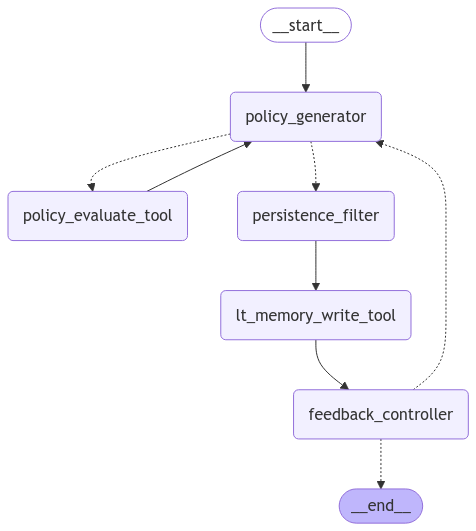

In [286]:
################################################################################
# Graph
################################################################################

from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

builder = StateGraph(State)

builder.add_node("policy_generator", policy_generator)
builder.add_node("policy_evaluate_tool", ToolNode([policy_evaluate_tool]))
builder.add_node("persistence_filter", persistence_filter)
builder.add_node("lt_memory_write_tool", ToolNode([lt_memory_write_tool]))
builder.add_node("feedback_controller", feedback_controller)

builder.add_edge(START, "policy_generator")
builder.add_conditional_edges("policy_generator", p_eval_conditional_edge,
                              ["policy_evaluate_tool", "persistence_filter"])
builder.add_edge("policy_evaluate_tool", "policy_generator")
builder.add_edge("persistence_filter", "lt_memory_write_tool")
builder.add_edge("lt_memory_write_tool", "feedback_controller")
builder.add_conditional_edges("feedback_controller", feedback_conditional_edge, ["policy_generator", END])

memory_saver = MemorySaver()
graph = builder.compile(checkpointer=memory_saver, interrupt_before=[])

display(Image(graph.get_graph().draw_mermaid_png()))

In [287]:
################################################################################
# Long-term Memory Cleanup
################################################################################

# Delete all the policies from the database
connection = sqlite3.connect("results/database.db")
cursor = connection.cursor()
cursor.execute("DELETE FROM lt_memory")
connection.commit()

cursor.execute(f"SELECT * FROM lt_memory")
assert len(cursor.fetchall()) == 0

connection.close()


In [288]:
################################################################################
# Invoke Graph
################################################################################

# Configurations
k = 5  # Number of policies
n = 5  # Number of iterations
f = 1  # F1-score threshold
c_reports = []
c_matrices = []

state = State(i=0, macro_f1s=0.5, messages=[])
state["messages"] = get_filtered_messages([], init=True)
config = {"configurable": {"thread_id": 1}, "recursion_limit": 6 * n + 1}
output = graph.invoke(state, config)

{'precision': 0.5596322676826239, 'recall': 0.5529428251121076, 'f1-score': 0.2023035409358747, 'support': 20000.0}
[[ 1889 15951]
 [    0  2160]]
{'precision': 0.5732177105216122, 'recall': 0.6480516110280684, 'f1-score': 0.3569903584874616, 'support': 20000.0}
[[ 5299 12541]
 [    2  2158]]
{'precision': 0.5732177105216122, 'recall': 0.6480516110280684, 'f1-score': 0.3569903584874616, 'support': 20000.0}
[[ 5299 12541]
 [    2  2158]]
{'precision': 0.6977633065570684, 'recall': 0.8558129878757681, 'f1-score': 0.7361433595020124, 'support': 20000.0}
[[15231  2609]
 [  307  1853]]
{'precision': 0.8891796494644596, 'recall': 0.9460886895864475, 'f1-score': 0.9149463930311714, 'support': 20000.0}
[[17304   536]
 [  168  1992]]


In [289]:
################################################################################
# Long-term Memory Visualizer
################################################################################

import datetime

policies = get_previous_policies()
print(tabulate(policies, headers="keys", tablefmt="grid"))

# Save this tabulate table to a file with name as the current timestamp
if len(policies) > 0:
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    file_name = f"results/policies-{timestamp}.txt"
    with open(file_name, "w") as file:
        try:
            llm_name = llm.model_name
        except AttributeError:
            llm_name = llm.model
        file.write(f">>> Results for {llm_name} of sample size {sample_size}\n\n")
        file.write(tabulate(policies, headers="keys", tablefmt="grid"))
        file.write("\n\n")
        for i in range(len(c_reports)):
            file.write(f"{c_reports[i]}\n")
            file.write(f"{c_matrices[i]}\n\n")



+-----------------+-------------+---------+------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| feature         | condition   |   value |   f1_score | comment                                                                                                                                                                                                         |
+=================+=============+=========+============+=================================================================================================================================================================================================================+
| Weight          | >           |   100   |   0.79926  | Initial policy.                                                                                                                               

In [20]:
for msg in output["messages"]:
    msg.pretty_print()

NameError: name 'output' is not defined

In [17]:
graph.get_state(config).next

Predicting attack entries...: 100%|█████████████████████████████| 100/100 [00:00<00:00, 9936.52it/s]


{'attack': {'precision': 0.6666666666666666, 'recall': 0.08, 'f1-score': 0.14285714285714285, 'support': 100.0}, 'normal': {'precision': 0.5106382978723404, 'recall': 0.96, 'f1-score': 0.6666666666666666, 'support': 100.0}, 'accuracy': 0.52, 'macro avg': {'precision': 0.5886524822695035, 'recall': 0.52, 'f1-score': 0.40476190476190477, 'support': 200.0}, 'weighted avg': {'precision': 0.5886524822695035, 'recall': 0.52, 'f1-score': 0.40476190476190466, 'support': 200.0}}
[[ 8 92]
 [ 4 96]]


In [69]:
output = graph.invoke(None, config)

[('flow_duration', '<', '0.87592973571767685', 'new policy'), ('HTTP', '>', '0.39908418869536888', 'new policy'), ('rst_count', '>', '0.071075293113404131', 'new policy'), ('psh_flag_number', '>', '0.42336309523809523', 'new policy'), ('syn_flag_number', '>', '0.548002700243609', 'new policy'), ('fin_count', '>', '0.4255740835304499', 'new policy')]


In [94]:
################################################################################
# Long-term Memory Read Tool
################################################################################

import sqlite3
from typing import List


@tool
def lt_memory_read_tool(features: List[str]) -> List:
    """Read the policies with the given features ['feature1', 'feature2', ...] from the SQL database."""

    try:
        # Create a connection to a SQLite database
        db_name = "results/database.db"
        connection = sqlite3.connect(db_name)

        # Read data from the database
        table_name = "lt_memory"
        cursor = connection.cursor()

        # Create the table if it does not exist
        cursor.execute(
            f"CREATE TABLE IF NOT EXISTS {table_name} (feature TEXT PRIMARY KEY, condition TEXT, value TEXT, f1_score TEXT, comment TEXT)")

        # Read the policies from the table
        cursor.execute(f"SELECT * FROM {table_name} WHERE feature IN ({', '.join(['?'] * len(features))})",
                       features)
        rows = cursor.fetchall()

        # Close the connection
        connection.close()

        return rows
    except Exception as e:
        print(e)
        return []

In [100]:
################################################################################
# Conditional Edge for Long-term Memory Read/Write
################################################################################

def ltm_rw_conditional_edge(state):
    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and (messages := state.get("messages", [])):
        ai_message = messages[-1]  # Default case
    elif messages := getattr(state, "messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # TODO: Implement the condition for long-term memory read/write
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        if ai_message.tool_calls[-1]["name"] == "lt_memory_read_tool":
            return "lt_memory_read_tool"
        elif ai_message.tool_calls[-1]["name"] == "lt_memory_write_tool":
            return "lt_memory_write_tool"
    return "feedback_controller"